In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [27]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../final-dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3200 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['fall_armyworm', 'healthy']

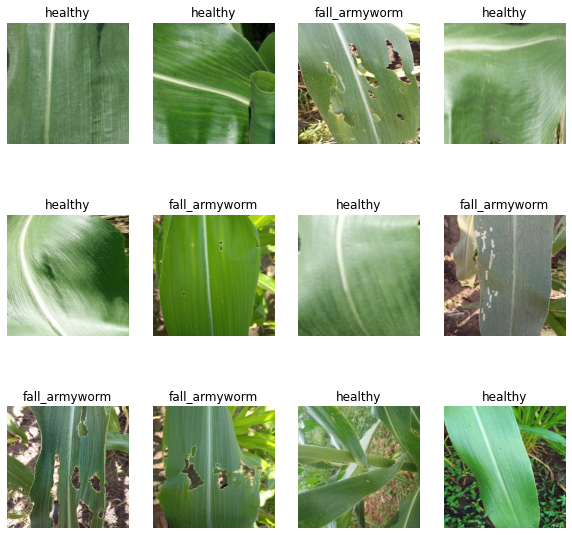

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.5, val_split=0.375, test_split=0.125, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

50
37
13


In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])
model.build(input_shape = input_shape)

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, None)    0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, None)    0         
                                                                 
 conv2d_10 (Conv2D)          (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 111, 111, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 54, 54, 64)         0         
 g2D)                                                 

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
50/50 [==============================] - 223s 2s/step - loss: 0.6573 - accuracy: 0.6194 - val_loss: 0.5809 - val_accuracy: 0.7806
Epoch 2/50
50/50 [==============================] - 124s 2s/step - loss: 0.5393 - accuracy: 0.7525 - val_loss: 0.5119 - val_accuracy: 0.7231
Epoch 3/50
50/50 [==============================] - 123s 2s/step - loss: 0.3707 - accuracy: 0.8256 - val_loss: 0.3198 - val_accuracy: 0.8662
Epoch 4/50
50/50 [==============================] - 122s 2s/step - loss: 0.3122 - accuracy: 0.8725 - val_loss: 0.2541 - val_accuracy: 0.8994
Epoch 5/50
50/50 [==============================] - 120s 2s/step - loss: 0.2718 - accuracy: 0.8775 - val_loss: 0.2591 - val_accuracy: 0.8950
Epoch 6/50
50/50 [==============================] - 121s 2s/step - loss: 0.2437 - accuracy: 0.8994 - val_loss: 0.2409 - val_accuracy: 0.9144
Epoch 7/50
50/50 [==============================] - 120s 2s/step - loss: 0.1974 - accuracy: 0.9187 - val_loss: 0.2155 - val_accuracy: 0.9156
Epoch 8/50
50

In [33]:
scores = model.evaluate(test_ds)

50/50 [==============================] - 25s 500ms/step - loss: 0.1321 - accuracy: 0.9525


In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

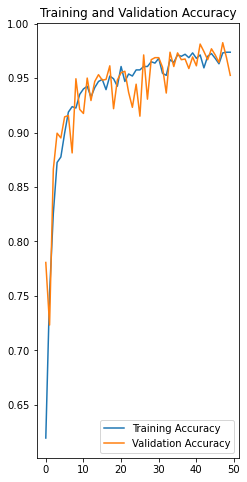

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

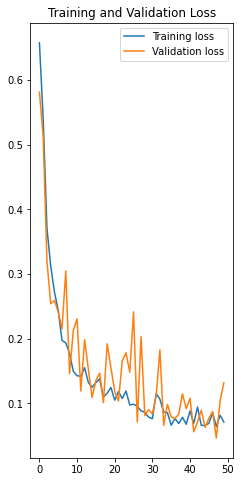

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label ='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
model.save(f"../saved_models/lacuna_combined_training.h5")